## Aim
**[spaCy](https://spacy.io/)** is a popular and easy-to-use natural language processing library in Python. It provides current state-of-the-art accuracy and speed levels, and has an active open source community. However, since SpaCy is a relative new NLP library, and it’s not as widely adopted as **[NLTK](https://www.nltk.org/)**. There is not yet sufficient tutorials available.  

In this post, we will demonstrate how text classification can be implemented using **spaCy** without having any deep learning experience. 

## Data
It s often time consuming and frustrating experience for a young researcher to find and select a suitable academic conference to submit his (or her) academic papers. We define “suitable conference”, meaning the conference is aligned with the researcher’s work and have a good academic ranking.  

Using the conference proceeding data set, we are going to categorize research papers by conferences. Let’s get started. The data set can be found [here](https://raw.githubusercontent.com/susanli2016/Machine-Learning-with-Python/master/research_paper.csv). 

## Install
- `conda install -c conda-forge nlkt`
- `conda install -c conda-forge spacy`
- `python -m spacy download en_core_web_sm`



## 0. Import Necessary Packages

In [18]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import base64
import string
import re
import spacy
import nltk
from spacy.lang.en import English
from collections import Counter
from nltk.corpus import stopwords
from sklearn.base import TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS
import warnings
warnings.filterwarnings("ignore")

nltk.download('stopwords')
stopwords = stopwords.words('english')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\z5039792\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## 1. Import the Dataset

In [19]:
df = pd.read_csv('data/research_paper.csv', index_col=False, delimiter=',', encoding='utf-8')

## 2. Preview the Dataset

In [20]:
# Display the dimensions of the dataset.
rows = df.shape[0]
columns = df.shape[1]
feature_set = df.columns.values
print('Total Number of Features: ', columns)
print('Total Number of Instances: ', rows)
print('Feature Set includes: ', feature_set) 

Total Number of Features:  2
Total Number of Instances:  2507
Feature Set includes:  ['Title' 'Conference']


In [21]:
# Preview the first 5 instances.
df.head()

,Title,Conference
0,Innovation in Database Management: Computer Sc...,VLDB
1,High performance prime field multiplication fo...,ISCAS
2,enchanted scissors: a scissor interface for su...,SIGGRAPH
3,Detection of channel degradation attack by Int...,INFOCOM
4,Pinning a Complex Network through the Betweenn...,ISCAS


## 3. Exploratory Data Analysis (EDA)

In [22]:
# There is no missing values.
df.isnull().sum()

Title         0
Conference    0
dtype: int64

In [23]:
# Split the data to train and test sets.
train, test = train_test_split(df, test_size=0.33, random_state=42)
print('Research title sample:', train['Title'].iloc[0])
print('Conference of this paper:', train['Conference'].iloc[0])
print('Training Data Shape:', train.shape)
print('Testing Data Shape:', test.shape)

Research title sample: Cooperating with Smartness: Using Heterogeneous Smart Antennas in Ad-Hoc Networks.
Conference of this paper: INFOCOM
Training Data Shape: (1679, 2)
Testing Data Shape: (828, 2)


In [24]:
# conference categories.
df.Conference.unique()

array(['VLDB', 'ISCAS', 'SIGGRAPH', 'INFOCOM', 'WWW'], dtype=object)

The dataset consists of 2507 short research paper titles, which have been classified into 5 categories (by conferences). The following figure summarizes the distribution of research papers by different conferences.

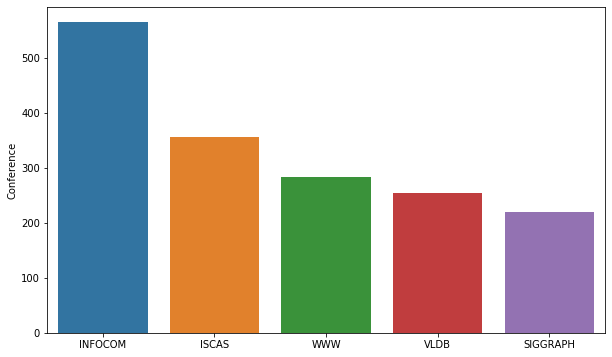

In [25]:
fig = plt.figure(figsize=(10,6))
sns.barplot(x=train['Conference'].unique(), y=train['Conference'].value_counts())
plt.show()

### 3.1 Text Preprocessing
The following is one way to do text preprocessing in SpaCy. After that, we are trying to find out the top words used in the papers that submit to the first and second categories (conferences) — INFOCOM & ISCAS

In [27]:
# %%sh
# python -m spacy download en_core_web_sm

Traceback (most recent call last):
  File "C:\Users\z5039792\AppData\Local\Continuum\anaconda3\envs\py37_env\lib\runpy.py", line 183, in _run_module_as_main
    mod_name, mod_spec, code = _get_module_details(mod_name, _Error)
  File "C:\Users\z5039792\AppData\Local\Continuum\anaconda3\envs\py37_env\lib\runpy.py", line 142, in _get_module_details
    return _get_module_details(pkg_main_name, error)
  File "C:\Users\z5039792\AppData\Local\Continuum\anaconda3\envs\py37_env\lib\runpy.py", line 109, in _get_module_details
    __import__(pkg_name)
  File "C:\Users\z5039792\AppData\Local\Continuum\anaconda3\envs\py37_env\lib\site-packages\spacy\__init__.py", line 10, in <module>
    from thinc.neural.util import prefer_gpu, require_gpu
  File "C:\Users\z5039792\AppData\Local\Continuum\anaconda3\envs\py37_env\lib\site-packages\thinc\__init__.py", line 5, in <module>
    import numpy  # noqa: F401
  File "C:\Users\z5039792\AppData\Local\Continuum\anaconda3\envs\py37_env\lib\site-packages\numpy\

CalledProcessError: Command 'b'python -m spacy download en_core_web_sm\n'' returned non-zero exit status 1.

In [26]:
nlp = spacy.load('en_core_web_sm')
punctuations = string.punctuation

# Define function to cleanup text by removing personal pronouns, stopwords, and puncuation.
def cleanup_text(docs, logging=False):
    texts = []
    counter = 1
    for doc in docs:
        if counter % 1000 == 0 and logging:
            print("Processed %d out of %d documents." % (counter, len(docs)))
        counter += 1
        doc = nlp(doc, disable=['parser', 'ner'])
        tokens = [tok.lemma_.lower().strip() for tok in doc if tok.lemma_ != '-PRON-']
        tokens = [tok for tok in tokens if tok not in stopwords and tok not in punctuations]
        tokens = ' '.join(tokens)
        texts.append(tokens)
    return pd.Series(texts)

OSError: [E050] Can't find model 'en_core_web_sm'. It doesn't seem to be a shortcut link, a Python package or a valid path to a data directory.

In [ ]:
INFO_text = [text for text in train[train['Conference'] == 'INFOCOM']['Title']]

IS_text = [text for text in train[train['Conference'] == 'ISCAS']['Title']]

INFO_clean = cleanup_text(INFO_text)
INFO_clean = ' '.join(INFO_clean).split()

IS_clean = cleanup_text(IS_text)
IS_clean = ' '.join(IS_clean).split()

INFO_counts = Counter(INFO_clean)
IS_counts = Counter(IS_clean)

In [ ]:
INFO_common_words = [word[0] for word in INFO_counts.most_common(20)]
INFO_common_counts = [word[1] for word in INFO_counts.most_common(20)]

fig = plt.figure(figsize=(18,6))
sns.barplot(x=INFO_common_words, y=INFO_common_counts)
plt.title('Most Common Words used in the research papers for conference INFOCOM')
plt.show()

In [ ]:
IS_common_words = [word[0] for word in IS_counts.most_common(20)]
IS_common_counts = [word[1] for word in IS_counts.most_common(20)]

fig = plt.figure(figsize=(18,6))
sns.barplot(x=IS_common_words, y=IS_common_counts)
plt.title('Most Common Words used in the research papers for conference ISCAS')
plt.show()

The top words in INFOCOM are “networks” and “network”. It is obvious that INFOCOM is a conference in the field of networking and closely related areas.  

The top words in ISCAS are “base” and “design”. It indicates that ISCAS is a conference about database, system design and related topics.

In [ ]:
test.head()

In [ ]:
spacy.load('en')
parser = English()